In [2]:
#My path
path = '/Users/claes/Documents/Mine dokumenter/Universitet/7.semester/Deep_learning/Final project/data/dataset/Revco/'

path_data = '/Users/claes/Documents/GitHub/DeepLearningProject/Data/'

#Your path
#path = '/Users/claes/Desktop/Deep_learning/Week_6'

In [3]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load the data
df = pd.read_parquet(path + 'combined_cleaned_data.parquet')

data_normalized = df.to_numpy()

# Create a custom Dataset class
class FreezerDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x = self.data[index]
        return x, x  # For autoencoders, input and target are the same

# Create the dataset and dataloaders
freezer_dataset = FreezerDataset(data_normalized)
batch_size = 2048
train_loader = DataLoader(freezer_dataset, batch_size=batch_size, shuffle=True)

In [4]:
import torch.nn as nn

# Define the number of features (i.e., columns in your dataset)
num_features = data_normalized.shape[1]

class AutoEncoder(nn.Module):
    def __init__(self, hidden_units, latent_features=2):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=num_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=latent_features)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=num_features)
        )

    def forward(self, x): 
        z = self.encoder(x)
        x_hat = torch.sigmoid(self.decoder(z))
        return {'z': z, 'x_hat': x_hat}

# Initialize the autoencoder model
hidden_units = 64
latent_features = 2
net = AutoEncoder(hidden_units, latent_features)
cuda = torch.cuda.is_available()

if cuda:
    net = net.cuda()

print(net)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=11, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=11, bias=True)
  )
)


In [5]:
import torch
cuda = torch.cuda.is_available()
print(f"Model is on GPU: {next(net.parameters()).is_cuda}")

Model is on GPU: True


In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn

# Initialize the optimizer and loss function
optimizer = optim.Adam(net.parameters(), lr=0.0005)
loss_function = nn.MSELoss()

num_epochs = 10
train_loss = []

# Move the model to the GPU if available
if cuda:
    net = net.cuda()

for epoch in range(num_epochs):
    batch_loss = []
    net.train()
    
    for x, _ in train_loader:
        # Move input data to GPU if available
        if cuda:
            x = x.cuda()
        
        # Forward pass
        outputs = net(x)
        x_hat = outputs['x_hat']
        
        # Compute the loss
        loss = loss_function(x_hat, x)
        
        # Backward pass and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Store the batch loss
        batch_loss.append(loss.item())
    
    train_loss.append(np.mean(batch_loss))
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss[-1]:.4f}")

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [24]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Initialize the optimizer and loss function
optimizer = optim.Adam(net.parameters(), lr=0.0005)
loss_function = nn.MSELoss()

num_epochs = 10
train_loss = []

# Move the model to the GPU if available
if cuda:
    net = net.cuda()

# Lists to store reconstruction errors and latent space representations
all_reconstruction_errors = []
latent_space = []

# Training loop
for epoch in range(num_epochs):
    batch_loss = []
    net.train()
    
    for x, _ in train_loader:
        # Move input data to GPU if available
        if cuda:
            x = x.cuda()
        
        # Forward pass
        outputs = net(x)
        x_hat = outputs['x_hat']
        
        # Store latent representations if available
        if 'latent' in outputs:
            latent_space.extend(outputs['latent'].detach().cpu().numpy())
        
        # Compute the loss
        loss = loss_function(x_hat, x)
        
        # Backward pass and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Store the batch loss
        batch_loss.append(loss.item())
        
        # Calculate and store reconstruction errors (fixed line)
        reconstruction_error = torch.mean((x - x_hat) ** 2, dim=1).detach().cpu().numpy()
        all_reconstruction_errors.extend(reconstruction_error)
    
    train_loss.append(np.mean(batch_loss))
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss[-1]:.4f}")

Epoch 1/10, Loss: 0.0041
Epoch 2/10, Loss: 0.0027
Epoch 3/10, Loss: 0.0025
Epoch 4/10, Loss: 0.0024
Epoch 5/10, Loss: 0.0024
Epoch 6/10, Loss: 0.0023
Epoch 7/10, Loss: 0.0023
Epoch 8/10, Loss: 0.0023
Epoch 9/10, Loss: 0.0023
Epoch 10/10, Loss: 0.0023


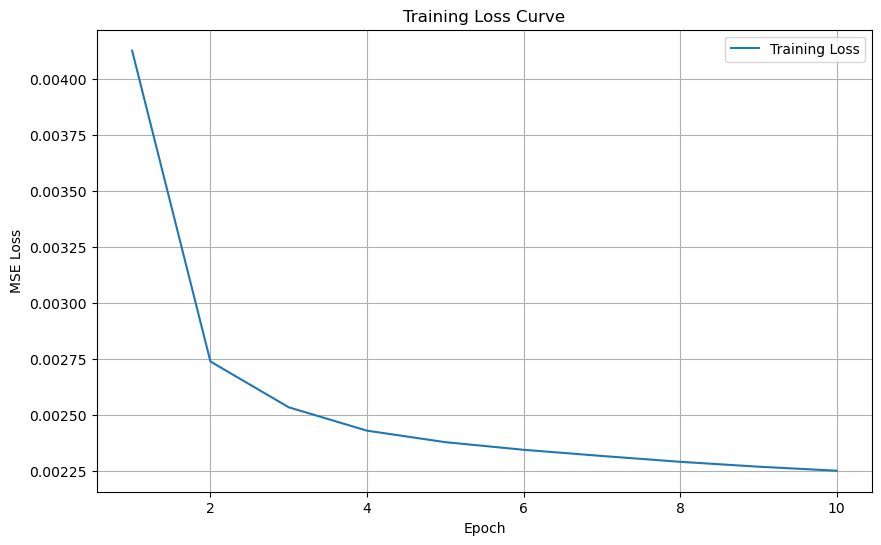

In [25]:
# Plot the training loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_loss, label='Training Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Plot the reconstruction error distribution
plt.figure(figsize=(10, 6))
plt.hist(all_reconstruction_errors, bins=50, alpha=0.75)
plt.axvline(x=0.05, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
if latent_space:
    latent_space = np.array(latent_space)
    
    # If latent space is high-dimensional, reduce it to 2D using PCA
    if latent_space.shape[1] > 2:
        pca = PCA(n_components=2)
        latent_space_2d = pca.fit_transform(latent_space)
    else:
        latent_space_2d = latent_space

    # Plot the 2D latent space
    plt.figure(figsize=(10, 6))
    plt.scatter(latent_space_2d[:, 0], latent_space_2d[:, 1], alpha=0.5)
    plt.title('Latent Space Representation')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.grid(True)
    plt.show()

NameError: name 'latent_space' is not defined

In [ ]:
# Visualize original vs reconstructed samples
net.eval()
x, _ = next(iter(train_loader))
if cuda:
    x = x.cuda()

with torch.no_grad():
    outputs = net(x)
    x_hat = outputs['x_hat']

# Convert tensors to numpy for plotting
x = x.cpu().numpy()
x_hat = x_hat.cpu().numpy()

# Plot original vs reconstructed for the first few samples
num_samples = 5
fig, axes = plt.subplots(num_samples, 2, figsize=(10, 10))

for i in range(num_samples):
    # Original data
    axes[i, 0].plot(x[i], label='Original')
    axes[i, 0].set_title(f'Sample {i+1} - Original')
    
    # Reconstructed data
    axes[i, 1].plot(x_hat[i], label='Reconstructed', color='orange')
    axes[i, 1].set_title(f'Sample {i+1} - Reconstructed')

plt.tight_layout()
plt.show()

### Gem model

In [6]:
# Save only the model's state dictionary
model_save_path = 'autoencoder_weights.pth'
torch.save(net.state_dict(), model_save_path)
print(f"Model weights saved to {model_save_path}")

Model weights saved to autoencoder_weights.pth


### Hent model

In [6]:
# Create a new instance of your model
net_loaded = AutoEncoder(hidden_units=64, latent_features=2)

# Move the model to GPU if available
if cuda:
    net_loaded = net_loaded.cuda()

# Load the saved weights into the model
model_save_path = 'autoencoder_weights.pth'
net_loaded.load_state_dict(torch.load(model_save_path))
print(f"Model weights loaded from {model_save_path}")

# Set the model to evaluation mode if you are using it for inference
net_loaded.eval()

Model weights loaded from autoencoder_weights.pth


C:\Users\claes\AppData\Local\Temp\ipykernel_29944\1773006121.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net_loaded.load_state_dict(torch.load(model_save_path))


AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=11, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=11, bias=True)
  )
)

In [8]:
import matplotlib.pyplot as plt

def detect_anomalies(data, model, threshold=0.05):
    model.eval()
    data_tensor = torch.tensor(data, dtype=torch.float32)
    
    if cuda:
        data_tensor = data_tensor.cuda()
    
    with torch.no_grad():
        outputs = model(data_tensor)
        x_hat = outputs['x_hat']
        reconstruction_error = torch.mean((data_tensor - x_hat) ** 2, dim=1).cpu().numpy()
    
    anomalies = reconstruction_error > threshold
    return anomalies, reconstruction_error

## Afprøve på træningsdata

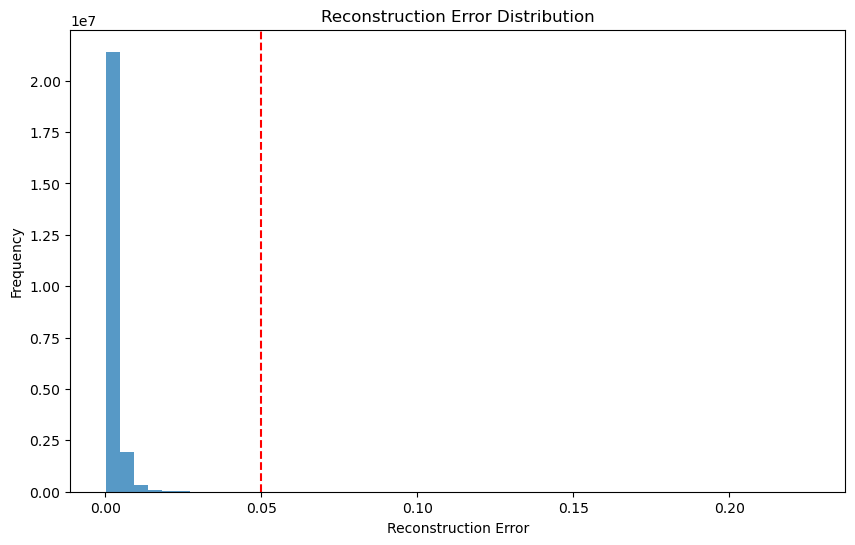

Detected 833 anomalies out of 23,794,494 samples.


In [9]:
anomalies, reconstruction_errors = detect_anomalies(data_normalized, net)

# Plot the reconstruction error distribution
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors, bins=50, alpha=0.75)
plt.axvline(x=0.05, color='r', linestyle='--')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()

# Print out the indices of anomalies
anomaly_indices = np.where(anomalies)[0]
print(f"Detected {len(anomaly_indices):,} anomalies out of {len(data_normalized):,} samples.")

## Afprøve på valid sæt

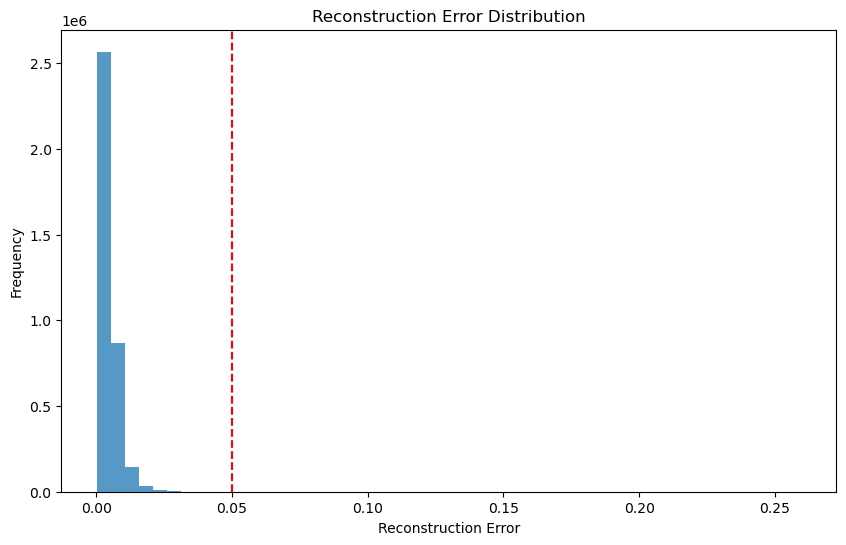

Detected 146 anomalies out of 3,623,505 samples.
Accuracy percentage: 0.00%


In [14]:
# Step 1: Load the data
#df = pd.read_parquet(path + 'around_events_data_806020.parquet')
df = pd.read_parquet(path + 'cleaned_data_806024.parquet')

# Step 2: Preprocess the data
#df.drop(columns=['Datetime', 'State', 'Type', 'Event'], inplace=True)
df.drop(columns=['Datetime', 'State', 'Type', 'Event', 'main_fault'], inplace=True)

# Step 3: Normalize the data
scaler = MinMaxScaler()
valid_data_normalized = scaler.fit_transform(df)

# Example: Detect anomalies on the training data
anomalies, reconstruction_errors = detect_anomalies(valid_data_normalized, net)

# Plot the reconstruction error distribution
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_errors, bins=50, alpha=0.75)
plt.axvline(x=0.05, color='r', linestyle='--')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()

# Print out the indices of anomalies
anomaly_indices = np.where(anomalies)[0]
percentage_accuracy = (len(anomaly_indices) / len(valid_data_normalized)) * 100
print(f"Detected {len(anomaly_indices):,} anomalies out of {len(valid_data_normalized):,} samples.")
print(f"Accuracy percentage: {percentage_accuracy:.2f}%")

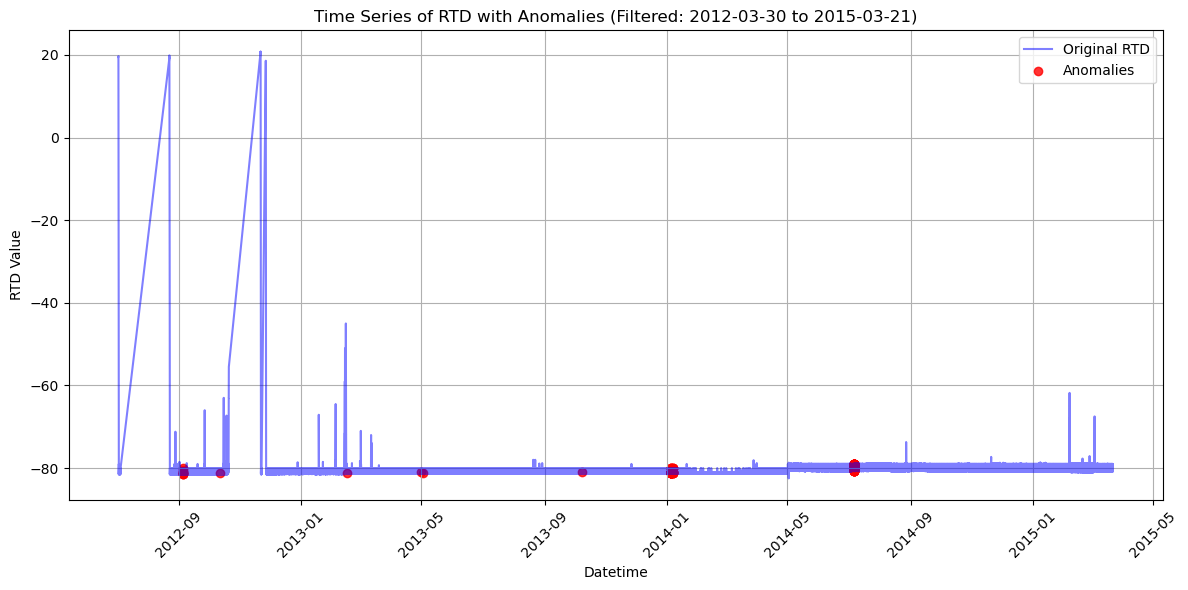

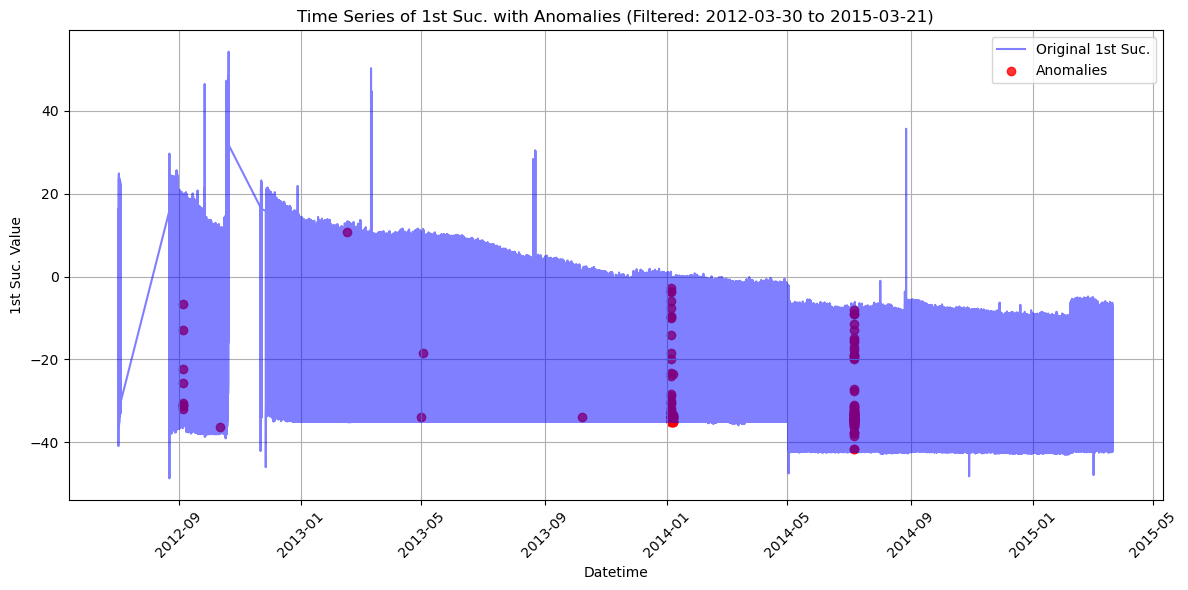

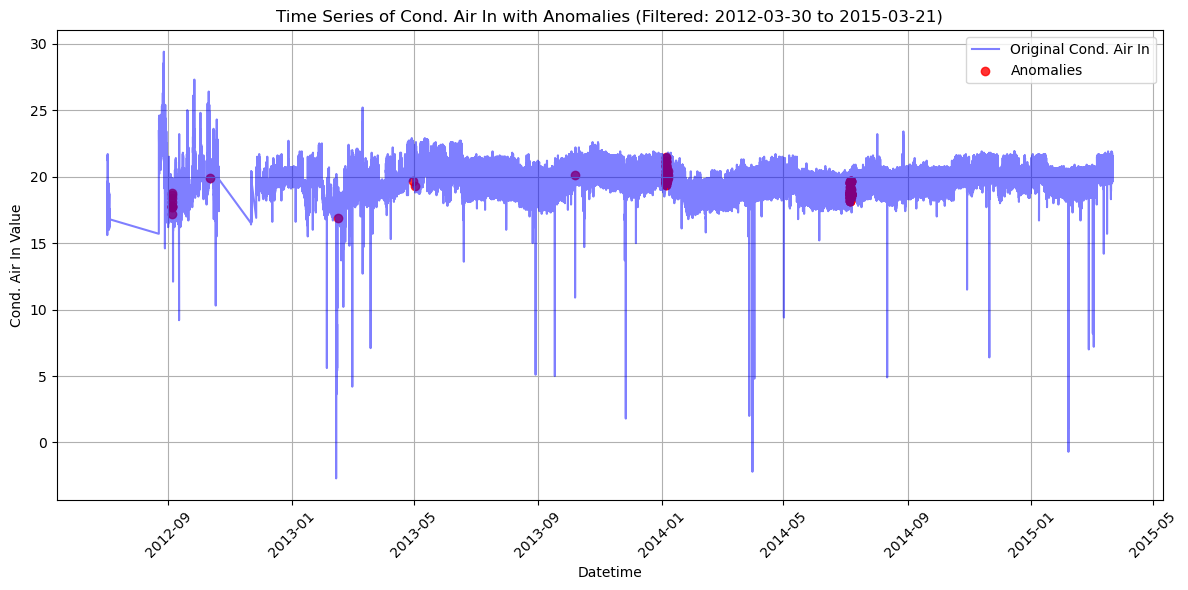

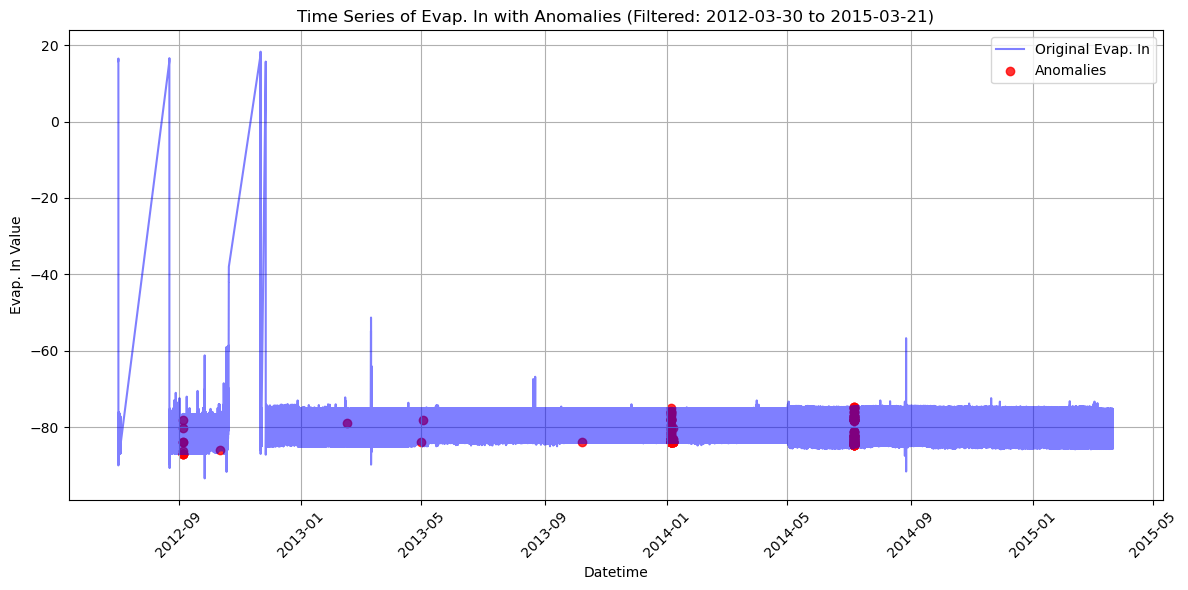

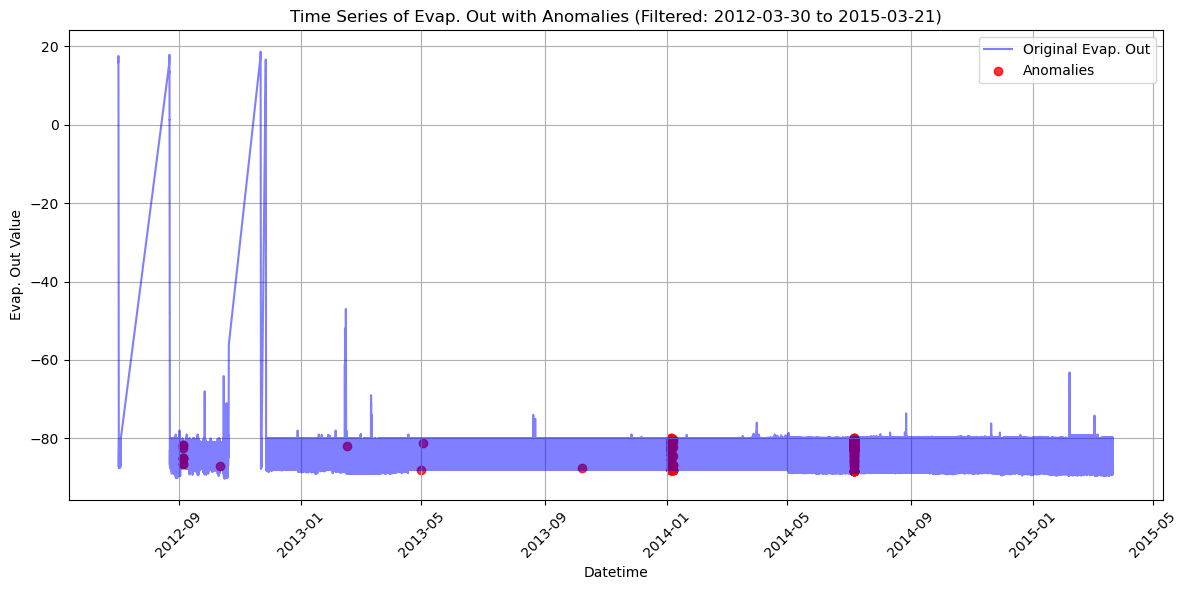

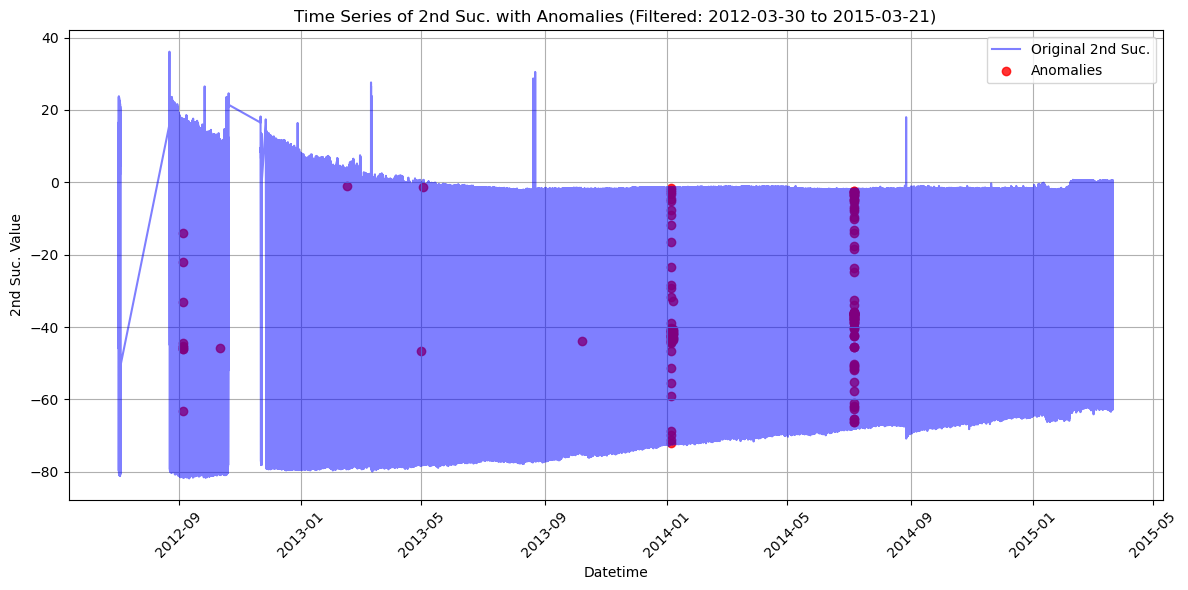

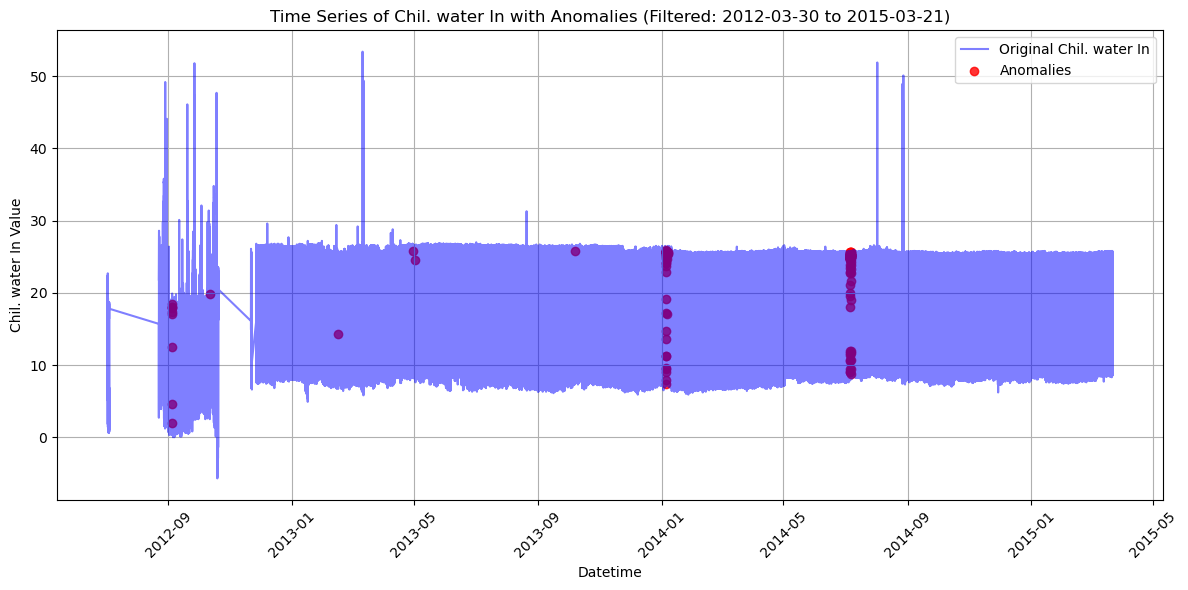

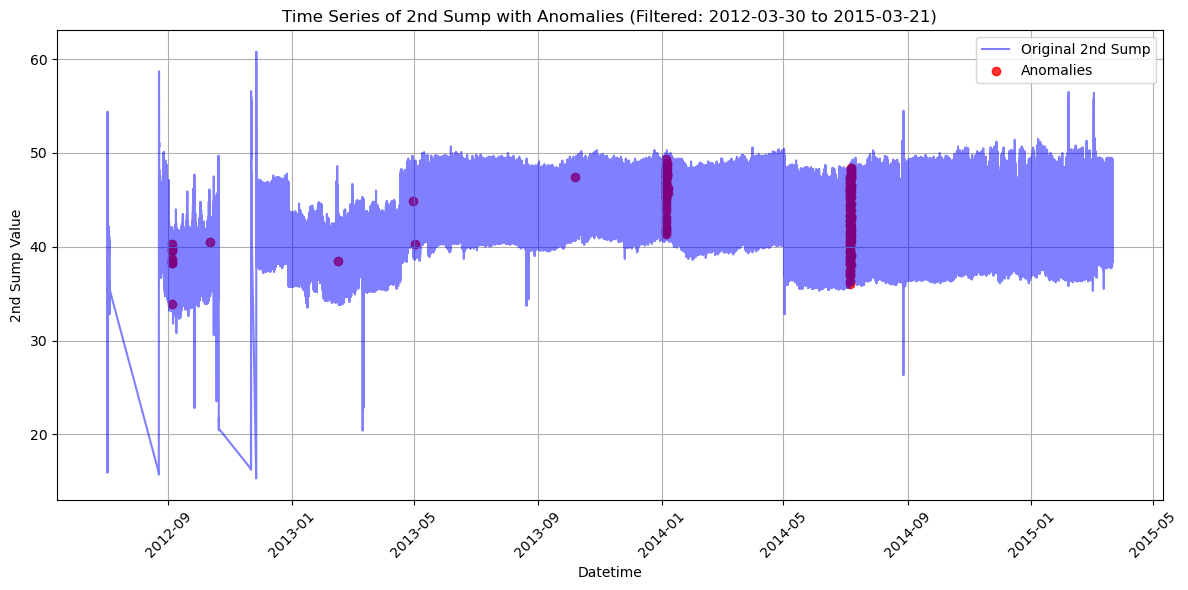

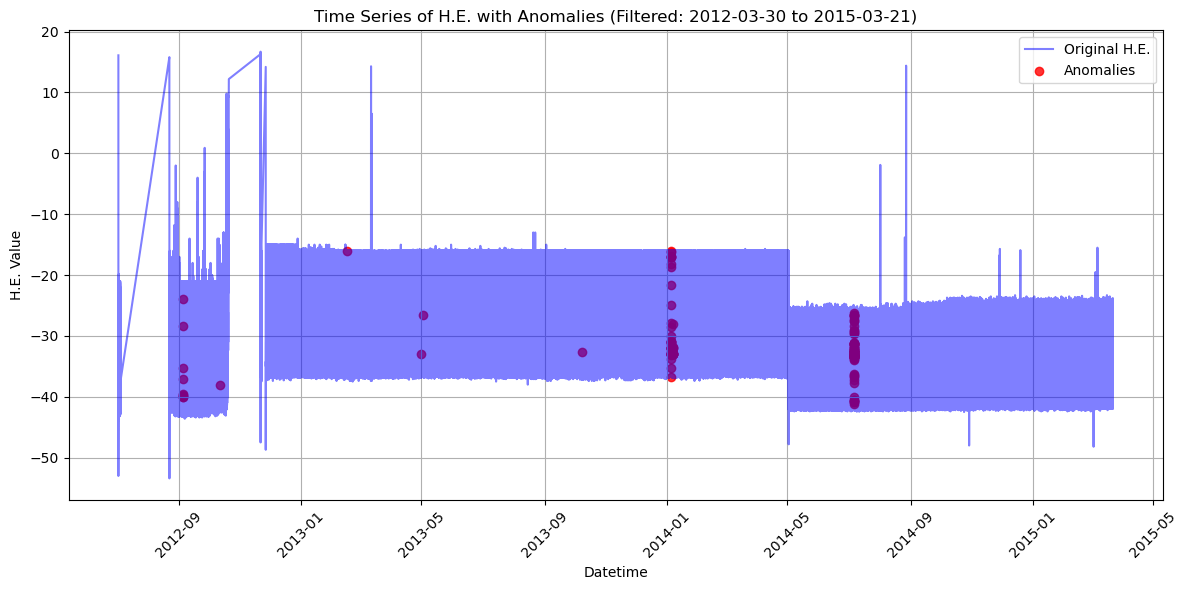

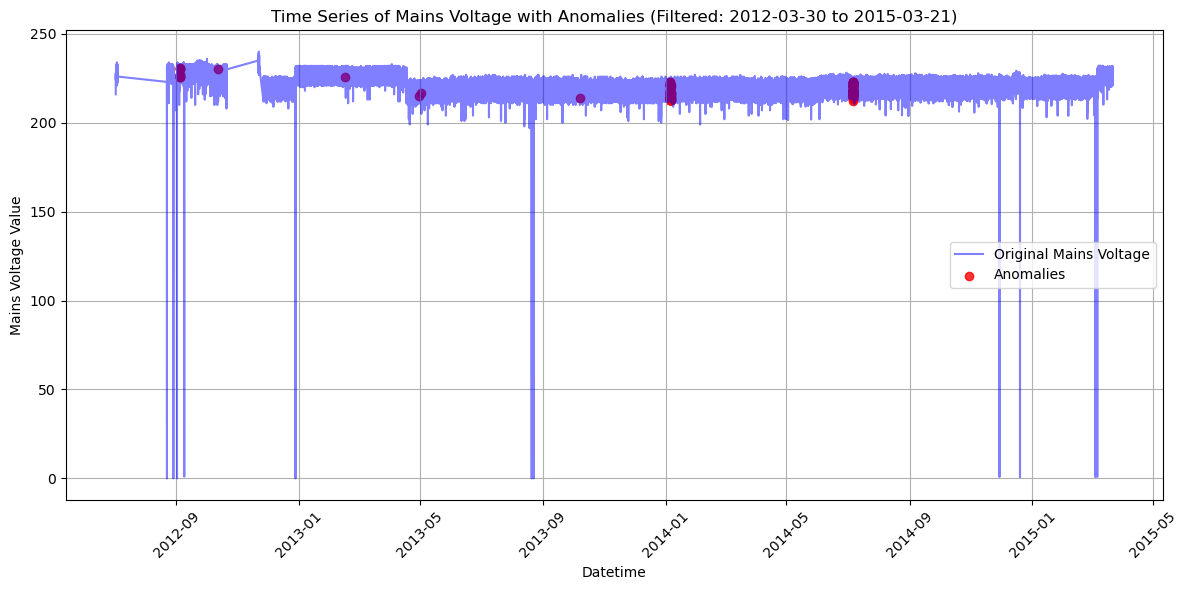

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Freezer_number = 806018

# Parameters
start_date = '2012-03-30'
end_date = '2023-03-21'

# Read the original Parquet file into a DataFrame
df_original = pd.read_parquet(path + str(Freezer_number) + '_temp.parquet')

# Convert 'Datetime' to datetime type if not already done
df_original['Datetime'] = pd.to_datetime(df_original['Datetime'])

# Set 'Datetime' as the index for easier plotting
df_original.set_index('Datetime', inplace=True)

# Filter the DataFrame to the specified date range
df_original_filtered = df_original.loc[start_date:end_date]

# Convert the filtered DataFrame to a NumPy array for anomaly mapping
df_original_values = df_original_filtered.to_numpy()

# Use the detected anomalies to filter the dates
anomaly_dates = df_original_filtered.index[anomaly_indices]

# Select only numeric columns for plotting
numeric_columns = df_original_filtered.select_dtypes(include=['float64', 'int64']).columns

# Plot each numeric column, highlighting anomalies
for col in numeric_columns:
    plt.figure(figsize=(12, 6))
    
    # Plot original data in blue
    plt.plot(df_original_filtered.index, df_original_filtered[col], label=f'Original {col}', color='blue', alpha=0.5)
    
    # Overlay anomalies in red
    plt.scatter(anomaly_dates, df_original_filtered.loc[anomaly_dates, col], 
                color='red', label='Anomalies', alpha=0.8)
    
    # Customize plot appearance
    plt.title(f"Time Series of {col} with Anomalies (Filtered: {start_date} to {end_date})")
    plt.xlabel("Datetime")
    plt.ylabel(f"{col} Value")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.show()